In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import random
import math
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.metrics import confusion_matrix

import seaborn as sns

# Import data

In [2]:
def fix_mat(data):
    if data.dtype.names:
        new_data = dict()
        for name in data.dtype.names:
            new_data[name]=data[0][name][0]
        for k,v in new_data.items():
            if v.dtype.names:
                new_data[k] = fix_mat(v)
            else:
                new_data[k] = np.squeeze(v)
        return new_data
    else:
        return data

In [3]:
subject = 'c72vis'
# path = '/home/paolo/cvsa_ws/record/' + subject + '/dataset/logband_d_cf_band_814.mat'
# path = '/home/paolo/cvsa_ws/record/' + subject + '/dataset/logband_e_cf_band_814.mat'
path = '/home/paolo/cvsa_ws/record/' + subject + '/dataset/logband_f_cf_selectedband1.mat'
data = loadmat(path)

X = fix_mat(data['X'])
y = fix_mat(data['y']).ravel()
info = fix_mat(data['info'])

if 'logband' in path:
    type_ = 'logbandpower'
else:
    type_ = 'psd'


In [5]:
# start using last n-1 files as test set
n = 3
start_test = info['startNewFile'][-n]

X_train = X[:start_test,:]
y_train = y[:start_test].ravel()
X_test = X[start_test:,:]
y_test = y[start_test:].ravel()

print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (4716, 4) (4716,)
Test set: (6924, 4) (6924,)


In [5]:
# test-train divsion by 0.75 (take the cf in which the starting sample is)
start_test = info['startTest']

X_test = X[:start_test,:]
y_test = y[:start_test].ravel()
X_train = X[start_test:,:]
y_train = y[start_test:].ravel()

print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (1416, 6) (1416,)
Test set: (4646, 6) (4646,)


## useful functions

In [6]:
def print_cm(cm, title, tick_labels):

    # Create a heatmap
    plt.figure(figsize=(3,2))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)
    
    # Add labels and titles
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()
    
    # print accuracy
    print('Accuracy:', np.trace(cm)/np.sum(cm))
    print('Accuracy 730:', cm[0][0]/(cm[0][0]+cm[0][1]))
    print('Accuracy 731:', cm[1][1]/(cm[1][0]+cm[1][1]))

def print_cm_rej(model, X, y_true, th_rej, title, ticket_label):
    cm = [[0, 0], [0, 0]]
    y_probs = model.predict_proba(X)
    
    for idx_p in range(len(y_probs)):
        if y_true[idx_p] == 730 and y_probs[idx_p,0] > th_rej:
            cm[0][0] += 1 
        elif y_true[idx_p] == 730 and y_probs[idx_p, 1] > th_rej:
            cm[0][1] += 1
        elif y_true[idx_p] == 731 and y_probs[idx_p, 1] > th_rej:
            cm[1][1] += 1
        elif y_true[idx_p] == 731 and y_probs[idx_p, 0] > th_rej:
            cm[1][0] += 1
       
    print_cm(cm, title, ticket_label)

In [7]:
def accuracy_online(prob, hit, miss, timeout, target, ths):
        
    i1 = np.where(prob[:,0] > ths[0])[0]
    if len(i1) == 0:
        i1 = len(prob[:,0]) + 1
    else:
        i1 = i1[0]
    i2 = np.where(prob[:,0] < ths[1])[0]
    if len(i2) == 0:
        i2 = len(prob[:,0]) + 1
    else:
        i2 = i2[0]
        
        
    
    if (target == 730 and i1 < i2) or (target == 731 and i1 > i2):
        hit += 1
    elif (target == 730 and i1 > i2) or (target == 731 and i1 < i2):
        miss += 1
    elif i1 == i2:
        timeout += 1
        
    return hit, miss, timeout

In [8]:
def online_test(model, X, y, alpha, ths, th_rej):
    # look only test data
    %matplotlib widget
    y_inter = 0.5
    tmp = info['trialStart']
    cfStart = tmp[tmp >= start_test] - start_test
    cfDUR = info['trialDUR'].ravel()
    cfDUR = cfDUR[tmp >= start_test]
    
    maxDUR = np.max(cfDUR)
    

    fig, axs = plt.subplots(math.ceil(len(cfStart)/4), 4, sharex=True, sharey=True)
    fig.set_size_inches(15,10)

    hit, miss, timeout = 0, 0, 0

    # iteration over trials
    for i in range(len(cfStart)):
        
        c_start = cfStart[i]
        c_end = c_start + cfDUR[i]
        
        c_y = np.array([[y_inter, y_inter]])
        probs = model.predict_proba(X[c_start:c_end,:])
        pred = model_qda.predict(X[c_start:c_end,:])
        pred[pred==731]=0
        pred[pred==730]=1
        
        for prob in probs:
            if max(prob) > th_rej:
                c_t = alpha * c_y[-1,:] + (1 - alpha) * prob
                c_y = np.vstack([c_y, c_t])
            else:
                c_t = c_y[-1,:]
                c_y = np.vstack([c_y, c_t])
        
        prev_hit = hit
        prev_miss = miss
        prev_timeout = timeout
        [hit, miss, timeout] = accuracy_online(c_y, hit, miss, timeout, y[cfStart[i]], ths)
        
        axs[int(i/4), i%4].plot(c_y[:,0]) # first column is about 730 
        axs[int(i/4), i%4].scatter(range(len(pred)), pred, color='black')
        axs[int(i/4), i%4].hlines(y_inter, 0, len(c_y), colors='r')
        axs[int(i/4), i%4].set_xlim([0, maxDUR])
        axs[int(i/4), i%4].set_xticks(np.arange(0, maxDUR, 8))
        axs[int(i/4), i%4].set_xticklabels(np.arange(0, maxDUR, 8)/16.0)
        if hit-prev_hit != 0:
            c_title = f'{y[cfStart[i]]} hit'
        elif miss - prev_miss != 0:
            c_title = f'{y[cfStart[i]]} miss'
        elif timeout - prev_timeout != 0:
            c_title = f'{y[cfStart[i]]} timeout'
        axs[int(i/4), i%4].set_title(c_title)
    
    print(f'Online accuracy: {hit/(hit+miss+timeout)}, hit: {hit}, miss: {miss}, timeout: {timeout}')
    
    plt.tight_layout()
    plt.show()

In [9]:
def histo_prediction(X, model, nbins, classes):
    probs = model.predict_proba(X)
    figure = plt.figure(figsize=(5, 3))
    plt.hist(probs[:,0], bins=nbins)
    # Add title and labels
    plt.title('Probability Distribution of class ' + classes[0])
    plt.xlabel('Probability')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()
    

# QDA

## Training

In [10]:
param_grid = {'reg_param': [0.0, 0.1, 0.5, 1.0], 'priors': [None, [0.5, 0.5]]}

#grid_search = GridSearchCV(estimator=QuadraticDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=3).fit(X_train, y_train)
grid_search = GridSearchCV(estimator=QuadraticDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)

#print("Results: ", grid_search.cv_results_)
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 1.0}
Best score found:  0.6210678145838202


In [11]:
model_qda = QuadraticDiscriminantAnalysis(reg_param=grid_search.best_params_['reg_param'], store_covariance=True, priors=grid_search.best_params_['priors'])
model_qda.fit(X_train, y_train)

print(f'Accuracy train: {model_qda.score(X_train, y_train)}')
print(f'Accuracy test:  {model_qda.score(X_test, y_test)}')
print(f'Accuracy all:   {model_qda.score(X, y)}')

Accuracy train: 0.6195928753180662
Accuracy test:  0.5108318890814558
Accuracy all:   0.5548969072164949


In [13]:
# train su tutto il dataset
model_qda = QuadraticDiscriminantAnalysis(reg_param=grid_search.best_params_['reg_param'], store_covariance=True, priors=grid_search.best_params_['priors'])
model_qda.fit(X, y)

print(f'Accuracy all:   {model_qda.score(X, y)}')

Accuracy all:   0.6984493566479709


## Analisys on predictions

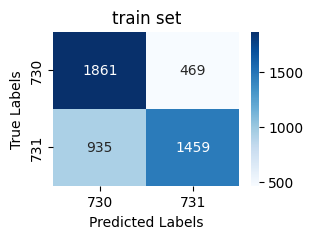

Accuracy: 0.7027942421676545
Accuracy 730: 0.7987124463519313
Accuracy 731: 0.6094402673350042


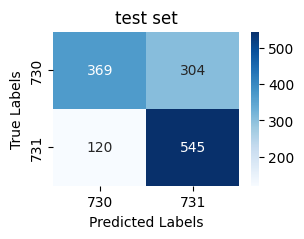

Accuracy: 0.6831091180866966
Accuracy 730: 0.5482912332838039
Accuracy 731: 0.8195488721804511


In [13]:
print_cm_rej(model_qda, X_train, y_train, 0.5, 'train set',  ['730', '731'])
print_cm_rej(model_qda, X_test,  y_test,  0.5, 'test set',  ['730', '731'])

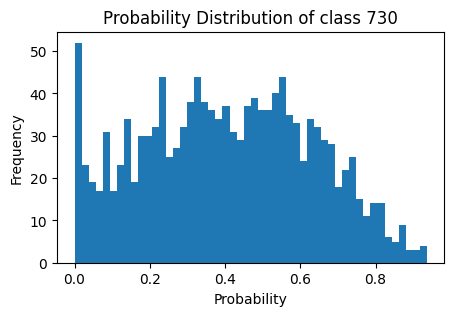

In [14]:
histo_prediction(X_test, model_qda, nbins=50, classes=['730', '731'])

In [249]:
online_test(model_qda, X_test, y_test, alpha=0.98, ths=[0.55, 0.45], th_rej=0.5)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 50 but corresponding boolean dimension is 100

## Save QDA

In [16]:
# Save the qda model for logbandpower --> for rosneuro_qda

from ruamel.yaml import YAML
from ruamel.yaml.comments import CommentedSeq
from ruamel.yaml.scalarstring import LiteralScalarString

means = ''
for i in range(0, len(model_qda.means_[0])):
    means = means + f'{model_qda.means_[0][i]} {model_qda.means_[1][i]};\n' 
covs = ""
for i in range(0, len(model_qda.covariance_[0][0])):
    for j in range(0, len(model_qda.covariance_[0][0])):
        covs = covs + f'{model_qda.covariance_[0][i][j]} {model_qda.covariance_[1][i][j]};\n'

features_label = []
for i in range(0, len(info['selchs'].tolist())):
    for j in range(0, len(info['selchs'].tolist()[i])):
        for k in range(0, len(info['selchs'].tolist()[i][j])):
            str_ch = info['selchs'][i][j][k][0]
            features_label.append(str(str_ch))

files = []
for i in range(0, len(info['files'])):
    str_file = info['files'][i][0]
    files.append(str(str_file))
    
band_str = ""
id_ch = []
for i in range(0, len(info['band'])):
    c_band = info['band'][i]
    c_idxch = info['idx_selchs'][i]
    for k in range(0, len(c_idxch)):
        band_str += str(float(c_band[0][0])) + " " + str(float(c_band[0][1])) + ";\n"
        id_ch.append(int(c_idxch[k]))
    
    
model_params = {
    'QdaCfg': {
        'name': "qda",
        'params': {
            'subject': subject,
            'filename': 'qda',
            'filename_dataset': path,
            'files': files,
            'type_data': type_,
            'nclasses': int(len(model_qda.classes_)),
            'classlbs': model_qda.classes_.tolist(),
            'nfeatures': int(model_qda.n_features_in_),
            'chans': features_label,
            'idchans': id_ch, 
            'sampleRate': int(info['sampleRate']),
            'band': LiteralScalarString(band_str),
            'filterOrder': int(info['filterOrder']),
            'priors': model_qda.priors_.tolist(),
            'means': LiteralScalarString(str(means)),
            'covs': LiteralScalarString(covs)
        }
    }
}
yaml = YAML()
yaml.default_flow_style = None 

#path = '/home/paolo/cvsa_ws/record/' + subject + '/qdaCfg.yaml'
path_qda = 'qdaCfg.yaml'

with open(path_qda, 'w') as file:
    yaml.dump(model_params, file)


In [15]:
# save qda model for sklearn
from ruamel.yaml import YAML
from ruamel.yaml.scalarstring import LiteralScalarString

features_label = []
for i in range(0, len(info['selchs'].tolist())):
    for j in range(0, len(info['selchs'].tolist()[i])):
        for k in range(0, len(info['selchs'].tolist()[i][j])):
            str_ch = info['selchs'][i][j][k][0]
            features_label.append(str(str_ch))

files = []
for i in range(0, len(info['files'])):
    str_file = info['files'][i][0]
    files.append(str(str_file))
    
band = []
id_ch = []
for i in range(0, len(info['band'])):
    c_band = info['band'][i]
    c_idxch = info['idx_selchs'][i]
    for k in range(0, len(c_idxch)):
        band.append([float(c_band[0][0]), float(c_band[0][1])])
        id_ch.append(int(c_idxch[k]))

model_params = {
    'QdaCfg': {
        'name': "qda",
        'params': {
            'subject': subject,
            'filename': 'qda',
            'filename_dataset': path,
            'files': files,
            'type_data': type_,
            'nclasses': int(len(model_qda.classes_)),
            'classlbs': model_qda.classes_.tolist(),
            'nfeatures': int(model_qda.n_features_in_),
            'chans': features_label,
            'idchans': id_ch, 
            'sampleRate': int(info['sampleRate']),
            'band': band,
            'filterOrder': int(info['filterOrder']),
            'priors': model_qda.priors_.tolist(),
            'means': model_qda.means_.tolist(),
            'covs': [arr.tolist() for arr in model_qda.covariance_],
            'rotations': [arr.tolist() for arr in model_qda.rotations_],
            'scalings': [arr.tolist() for arr in model_qda.scalings_]
        }
    }
}

# Save parameters to a YAML file
yaml = YAML()
with open('qda_params.yaml', 'w') as file:
    yaml.dump(model_params, file)

In [117]:
import yaml

# Load parameters from the YAML file
with open('qda_params.yaml', 'r') as file:
    params = yaml.safe_load(file)

In [118]:
# Create a new QDA model
qda = QuadraticDiscriminantAnalysis()

# Set the parameters
qda.priors_ = np.array(params['QdaCfg']['params']['priors'])
qda.means_ = np.array(params['QdaCfg']['params']['means'])
qda.rotations_ = np.array(params['QdaCfg']['params']['rotations'])
qda.scalings_ = np.array(params['QdaCfg']['params']['scalings'])
qda.covariance_ = np.array(params['QdaCfg']['params']['covs'])
qda.classes_ = np.array(params['QdaCfg']['params']['classlbs'])

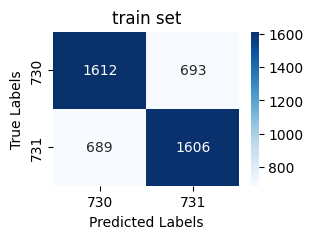

Accuracy: 0.6995652173913044
Accuracy 730: 0.6993492407809111
Accuracy 731: 0.6997821350762528


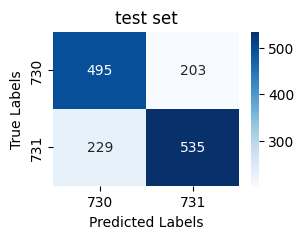

Accuracy: 0.7045143638850889
Accuracy 730: 0.7091690544412608
Accuracy 731: 0.7002617801047121


In [119]:
print_cm_rej(qda, X_train, y_train, 0.5, 'train set',  ['730', '731'])
print_cm_rej(qda, X_test,  y_test,  0.5, 'test set',  ['730', '731'])

# LDA

## Training

In [12]:
param_grid = {'solver': [ 'lsqr', 'eigen'], 'shrinkage': ['auto', None]}

#grid_search = GridSearchCV(estimator=LinearDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=3).fit(X_train, y_train)
grid_search = GridSearchCV(estimator=LinearDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)

print("Results: ", grid_search.cv_results_)
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Results:  {'mean_fit_time': array([0.02736144, 0.04073935, 0.02022843, 0.01371021]), 'std_fit_time': array([0.00308289, 0.00166279, 0.00150605, 0.00409378]), 'mean_score_time': array([0.00368047, 0.00246549, 0.00349226, 0.0016047 ]), 'std_score_time': array([8.39077599e-05, 5.98794838e-04, 4.03737788e-04, 4.83917377e-04]), 'param_shrinkage': masked_array(data=['auto', 'auto', None, None],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_solver': masked_array(data=['lsqr', 'eigen', 'lsqr', 'eigen'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'shrinkage': 'auto', 'solver': 'lsqr'}, {'shrinkage': 'auto', 'solver': 'eigen'}, {'shrinkage': None, 'solver': 'lsqr'}, {'shrinkage': None, 'solver': 'eigen'}], 'split0_test_score': array([0.66101695, 0.66101695, 0.66737288, 0.66737288]), 'split1_test_score': array([0.58854719, 0.58854719, 0.58218452, 0.58218452]), 'split2_test

In [13]:
model_lda = LinearDiscriminantAnalysis(solver=grid_search.best_params_['solver'], shrinkage=grid_search.best_params_['shrinkage'])
model_lda.fit(X_train, y_train)

print(f'Accuracy train: {model_lda.score(X_train, y_train)}')
print(f'Accuracy test:  {model_lda.score(X_test, y_test)}')
print(f'Accuracy all:   {model_lda.score(X, y)}')

Accuracy train: 0.6310432569974554
Accuracy test:  0.5135759676487579
Accuracy all:   0.5611683848797251


In [27]:
model_lda = LinearDiscriminantAnalysis(solver=grid_search.best_params_['solver'], shrinkage=grid_search.best_params_['shrinkage'])
model_lda.fit(X, y)
print(f'Accuracy all:   {model_lda.score(X, y)}')

Accuracy all:   0.7046808510638298


## Analisys prediction

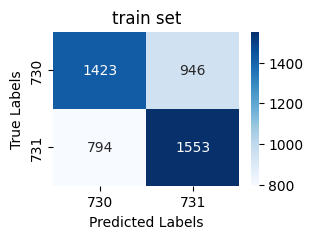

Accuracy: 0.6310432569974554
Accuracy 730: 0.6006753904601098
Accuracy 731: 0.6616957818491691


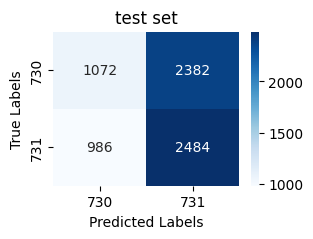

Accuracy: 0.5135759676487579
Accuracy 730: 0.31036479444122755
Accuracy 731: 0.715850144092219


In [14]:
print_cm_rej(model_lda, X_train, y_train, 0.5, 'train set',  ['730', '731'])
print_cm_rej(model_lda, X_test,  y_test,  0.5, 'test set',  ['730', '731'])

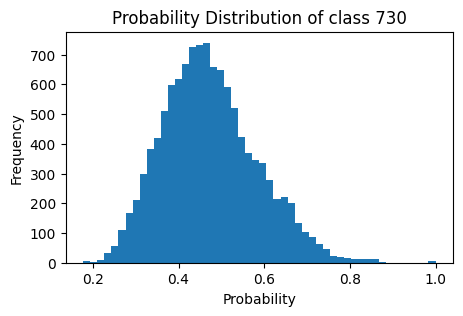

In [16]:
histo_prediction(X, model_lda, nbins=50, classes=['730', '731'])

Online accuracy: 0.55, hit: 11, miss: 8, timeout: 1


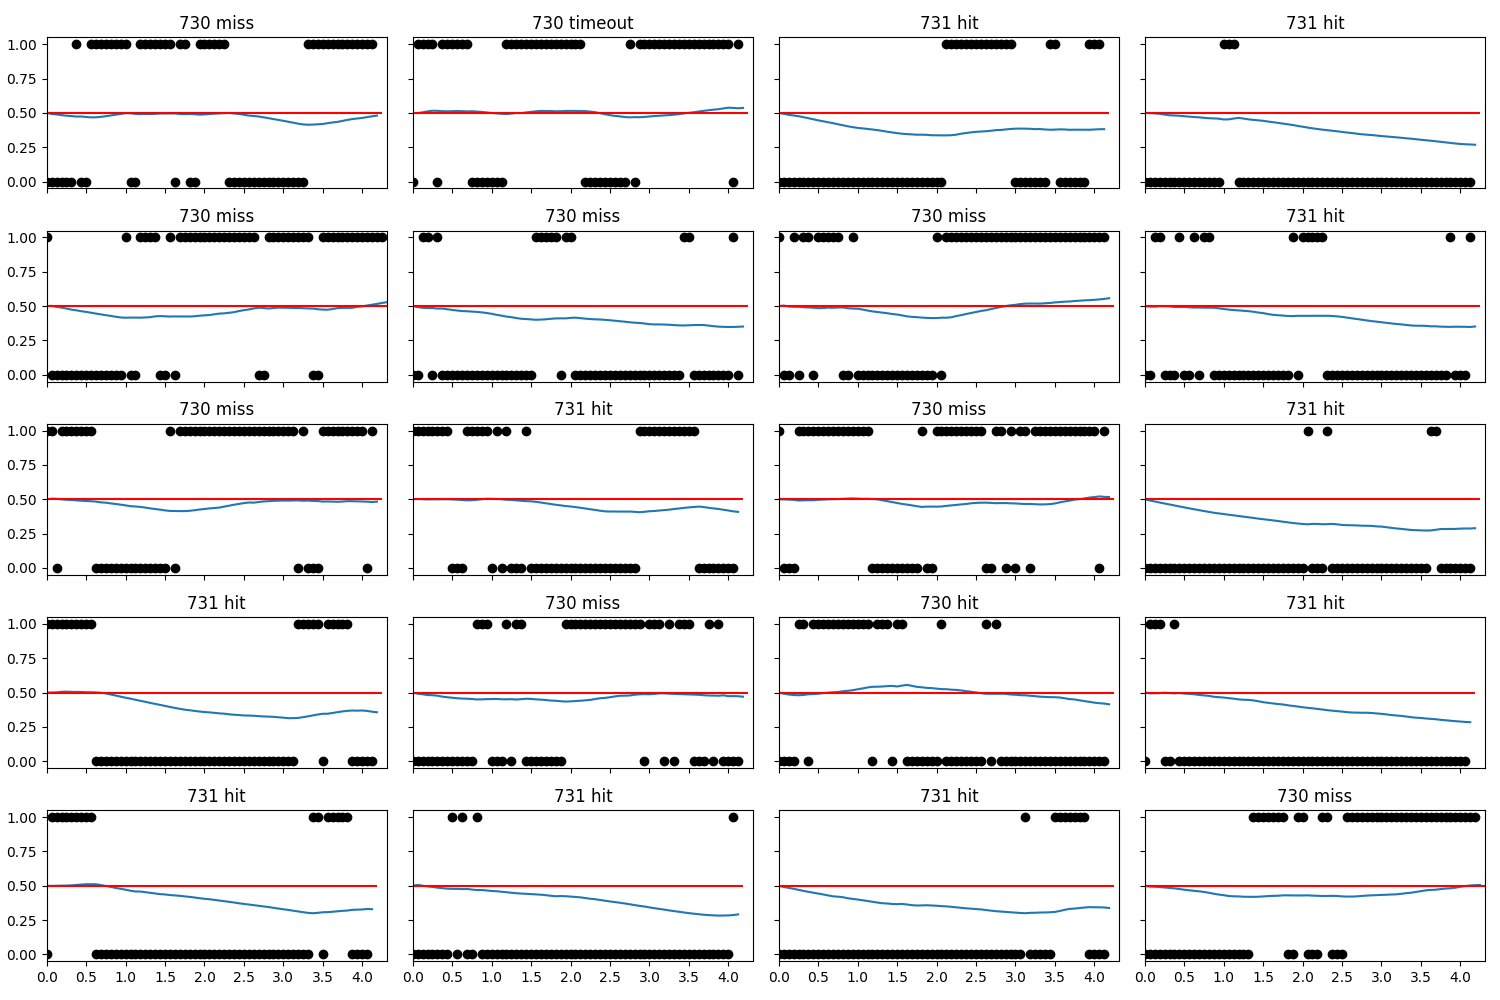

In [22]:
online_test(model_lda, X_test, y_test, alpha=0.98, ths=[0.55, 0.45], th_rej=0.5)

# SVM

## Training

In [262]:
from sklearn.svm import SVC

param_grid = {'kernel': [1.0 * RBF(length_scale=1.0), 2.0 * RBF(length_scale=1.0), 3.0 * RBF(length_scale=1.0), 2.0 * RBF(length_scale=2.0)],
              'C' : np.logspace(-2, 4, 3),
              'gamma' : np.logspace(-9, 3, 3)}

cv = [(np.arange(0,int(len(X_train)*0.7)), np.arange(int(len(X_train)*0.7), len(X_train)))]
grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=cv, n_jobs=-1).fit(X_train, y_train)
#grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=cv, n_jobs=-1, verbose=3).fit(X_train, y_train)

print("The best parameters are %s with a score of %0.4f" % (grid_search.best_params_, grid_search.best_score_))

The best parameters are {'C': 0.01, 'gamma': 1e-09, 'kernel': 1.73**2 * RBF(length_scale=1)} with a score of 0.6388


In [263]:
svm = SVC(kernel=grid_search.best_params_['kernel'], C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'], probability=True)
svm.fit(X_train, y_train)
print(f'Accuracy train: {svm.score(X_train, y_train)}')
print(f'Accuracy test:  {svm.score(X_test, y_test)}')
print(f'Accuracy all:   {svm.score(X, y)}')

Accuracy train: 0.607583774250441
Accuracy test:  0.6315128688010044
Accuracy all:   0.6174566174566175


## Analysis predictions

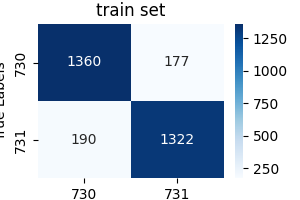

Accuracy: 0.8796326664480157
Accuracy 730: 0.8848405985686402
Accuracy 731: 0.8743386243386243


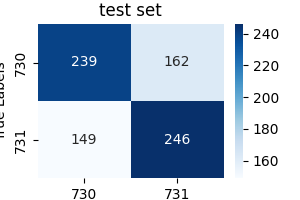

Accuracy: 0.6092964824120602
Accuracy 730: 0.5960099750623441
Accuracy 731: 0.6227848101265823


In [197]:
print_cm_rej(svm, X_train, y_train, 0.5, 'train set',  ['730', '731'])
print_cm_rej(svm, X_test,  y_test,  0.5, 'test set',  ['730', '731'])

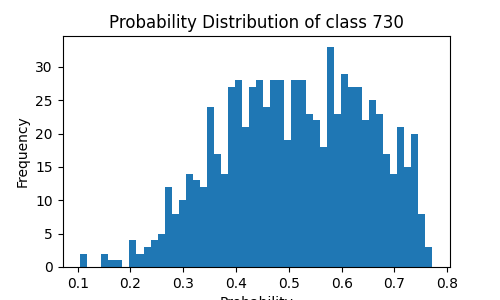

In [100]:
histo_prediction(X_test, svm, nbins=50, classes=['730', '731'])

Online accuracy: 0.5, hit: 5, miss: 0, timeout: 5


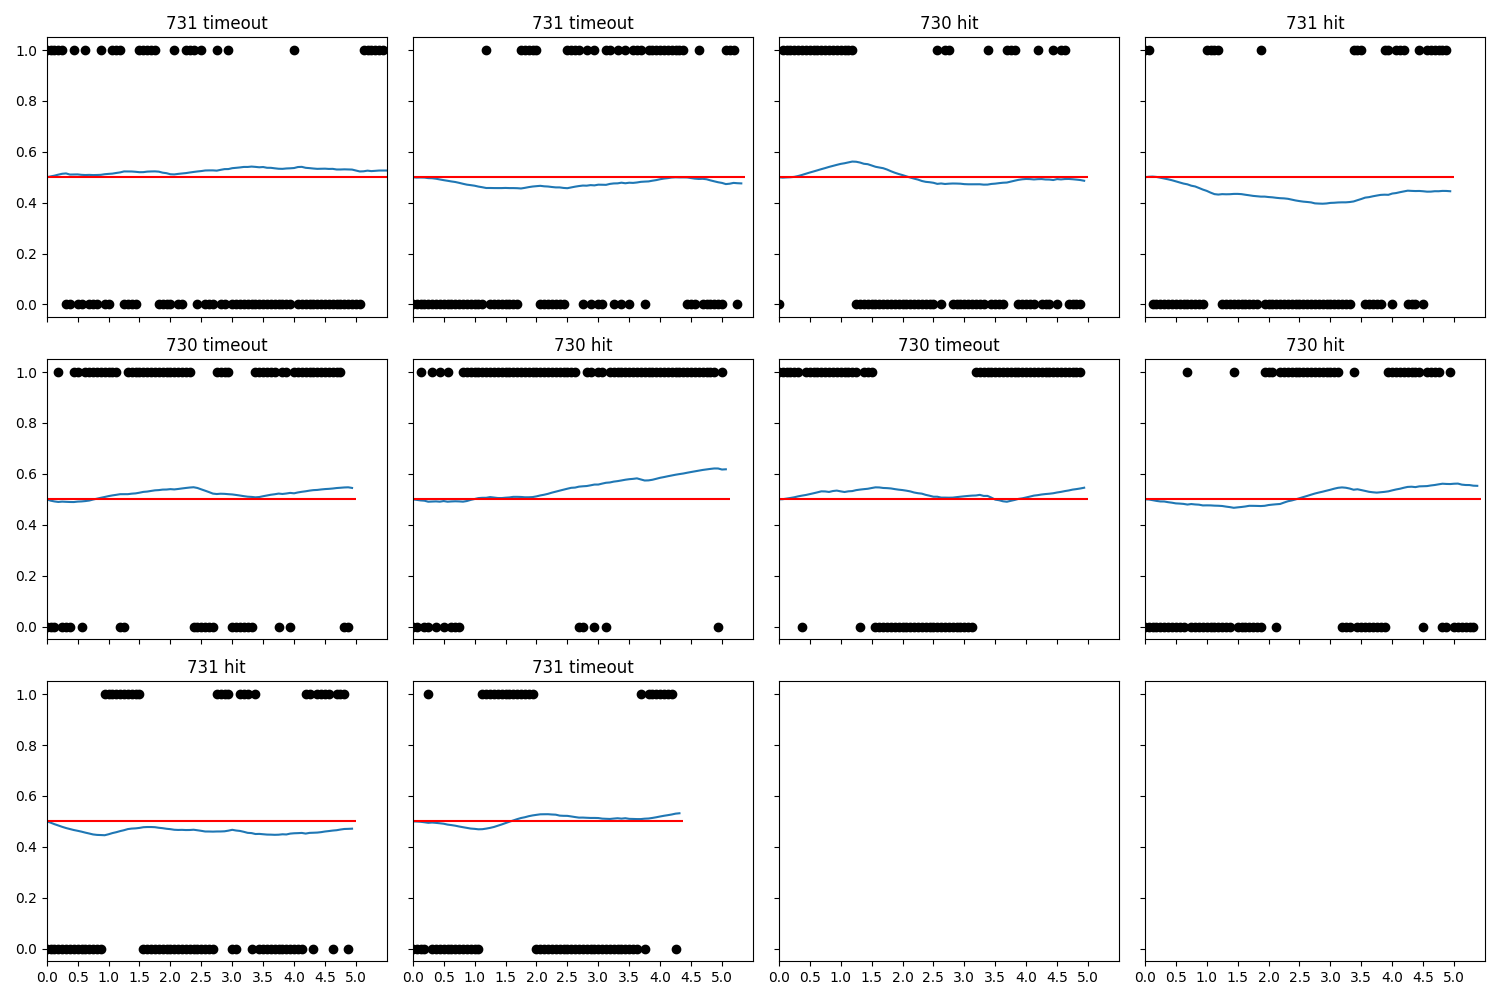

In [117]:
online_test(svm, X_test, y_test, alpha=0.98, ths=[0.55, 0.45], th_rej=0.5)

# Gaussian Decoder

## Training

In [17]:
param_grid = {'kernel': [1.0 * RBF(length_scale=1.0), 
                         1.0 * Matern(length_scale=1.0, nu=1.5)]}
#grid_search = GridSearchCV(estimator=GaussianProcessClassifier(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=3).fit(X_train, y_train)
grid_search = GridSearchCV(estimator=GaussianProcessClassifier(), param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)

print("Results: ", grid_search.cv_results_)
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Results:  {'mean_fit_time': array([337.17782526, 354.99241652]), 'std_fit_time': array([39.98027736, 26.57016181]), 'mean_score_time': array([0.0798213 , 0.10275178]), 'std_score_time': array([0.01691525, 0.02321173]), 'param_kernel': masked_array(data=[1**2 * RBF(length_scale=1),
                   1**2 * Matern(length_scale=1, nu=1.5)],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'kernel': 1**2 * RBF(length_scale=1)}, {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}], 'split0_test_score': array([0.62182203, 0.63135593]), 'split1_test_score': array([0.55355249, 0.55037116]), 'split2_test_score': array([0.58006363, 0.57794274]), 'split3_test_score': array([0.58536585, 0.58536585]), 'split4_test_score': array([0.56521739, 0.56945917]), 'mean_test_score': array([0.58120428, 0.58289897]), 'std_test_score': array([0.02318889, 0.02689763]), 'rank_test_score': array([2, 1], dtype=int32)}
Best parameters found:  {'kernel': 1**2 * Matern(len

In [18]:
model_gaussian = GaussianProcessClassifier(kernel=grid_search.best_params_['kernel'])
model_gaussian.fit(X_train, y_train)

print(f'Accuracy train: {model_gaussian.score(X_train, y_train)}')
print(f'Accuracy test:  {model_gaussian.score(X_test, y_test)}')
print(f'Accuracy all:   {model_gaussian.score(X, y)}')

Accuracy train: 0.7266751484308737
Accuracy test:  0.5300404390525708
Accuracy all:   0.6097079037800688


In [23]:
model_gaussian = GaussianProcessClassifier(kernel=grid_search.best_params_['kernel'])
model_gaussian.fit(X, y)

print(f'Accuracy all:   {model_gaussian.score(X, y)}')

Accuracy all:   0.7494226327944573


## Analisys predictions

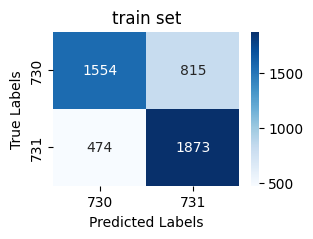

Accuracy: 0.7266751484308737
Accuracy 730: 0.6559729843815956
Accuracy 731: 0.7980400511291009


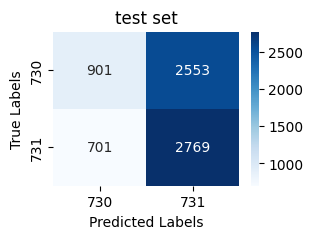

Accuracy: 0.5300404390525708
Accuracy 730: 0.260856977417487
Accuracy 731: 0.7979827089337176


In [19]:
print_cm_rej(model_gaussian, X_train, y_train, 0.5, 'train set',  ['730', '731'])
print_cm_rej(model_gaussian, X_test,  y_test,  0.5, 'test set',  ['730', '731'])

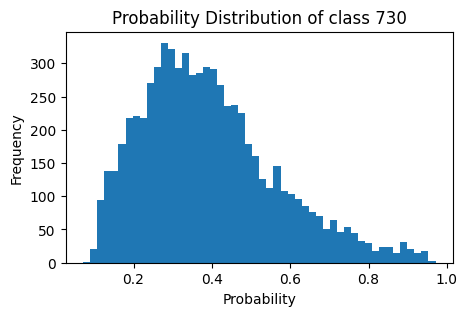

In [20]:
histo_prediction(X_test, model_gaussian, nbins=50, classes=['730', '731'])

Online accuracy: 0.9, hit: 18, miss: 1, timeout: 1


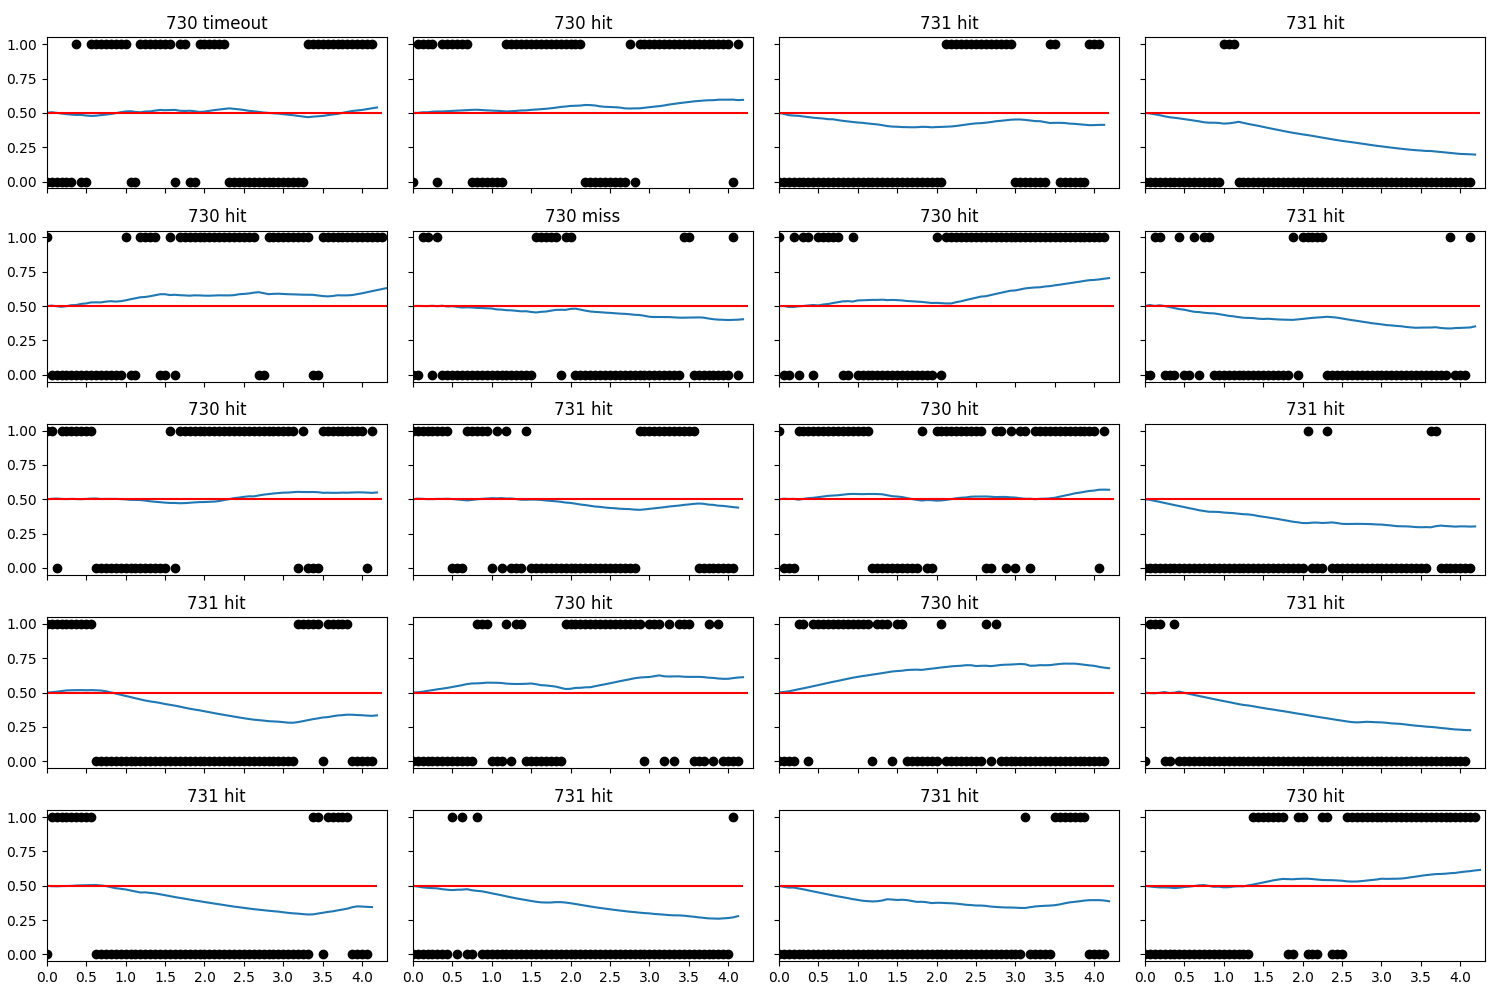

In [26]:
online_test(model_gaussian, X_test, y_test, alpha=0.98, ths=[0.55, 0.45], th_rej=0.5)

# Random Forest

## Training

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

model_rF = RandomForestClassifier()

param_dist = {'n_estimators': randint(0, 500), 'max_depth': randint(1, X.shape[1])}
#rand_search = RandomizedSearchCV(model_rF, param_distributions= param_dist, n_iter=15, cv=5, verbose=3).fit(X_train, y_train)
rand_search = RandomizedSearchCV(model_rF, param_distributions= param_dist, n_iter=15, cv=5).fit(X_train, y_train)

#print(rand_search.cv_results_)
#print('Best hyperparameters:', rand_search.best_params_)
print('Best score:', rand_search.best_score_)

Best score: 0.6577298850574713


In [21]:
model_rF = rand_search.best_estimator_
model_rF.fit(X_train, y_train)  

print(f'Accuracy train: {model_rF.score(X_train, y_train)}')
print(f'Accuracy test:  {model_rF.score(X_test, y_test)}')
print(f'Accuracy all:   {model_rF.score(X, y)}')

Accuracy train: 0.7867036011080333
Accuracy test:  0.5084745762711864
Accuracy all:   0.5999089667728721


## Analisys predictions

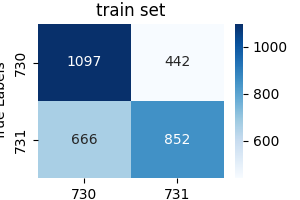

Accuracy: 0.6375531566895649
Accuracy 730: 0.7128005198180637
Accuracy 731: 0.5612648221343873


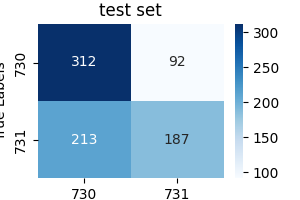

Accuracy: 0.6206467661691543
Accuracy 730: 0.7722772277227723
Accuracy 731: 0.4675


In [51]:
print_cm_rej(model_rF, X_train, y_train, 0.5, 'train set',  ['730', '731'])
print_cm_rej(model_rF, X_test,  y_test,  0.5, 'test set',  ['730', '731'])

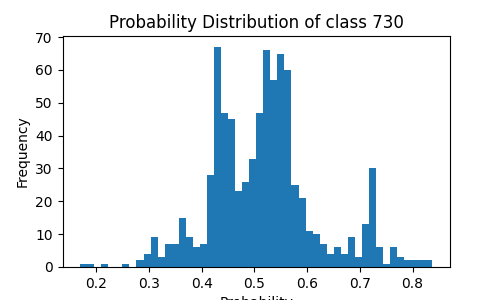

In [124]:
histo_prediction(X_test, model_rF, nbins=50, classes=['730', '731'])

Online accuracy: 0.2, hit: 2, miss: 0, timeout: 8


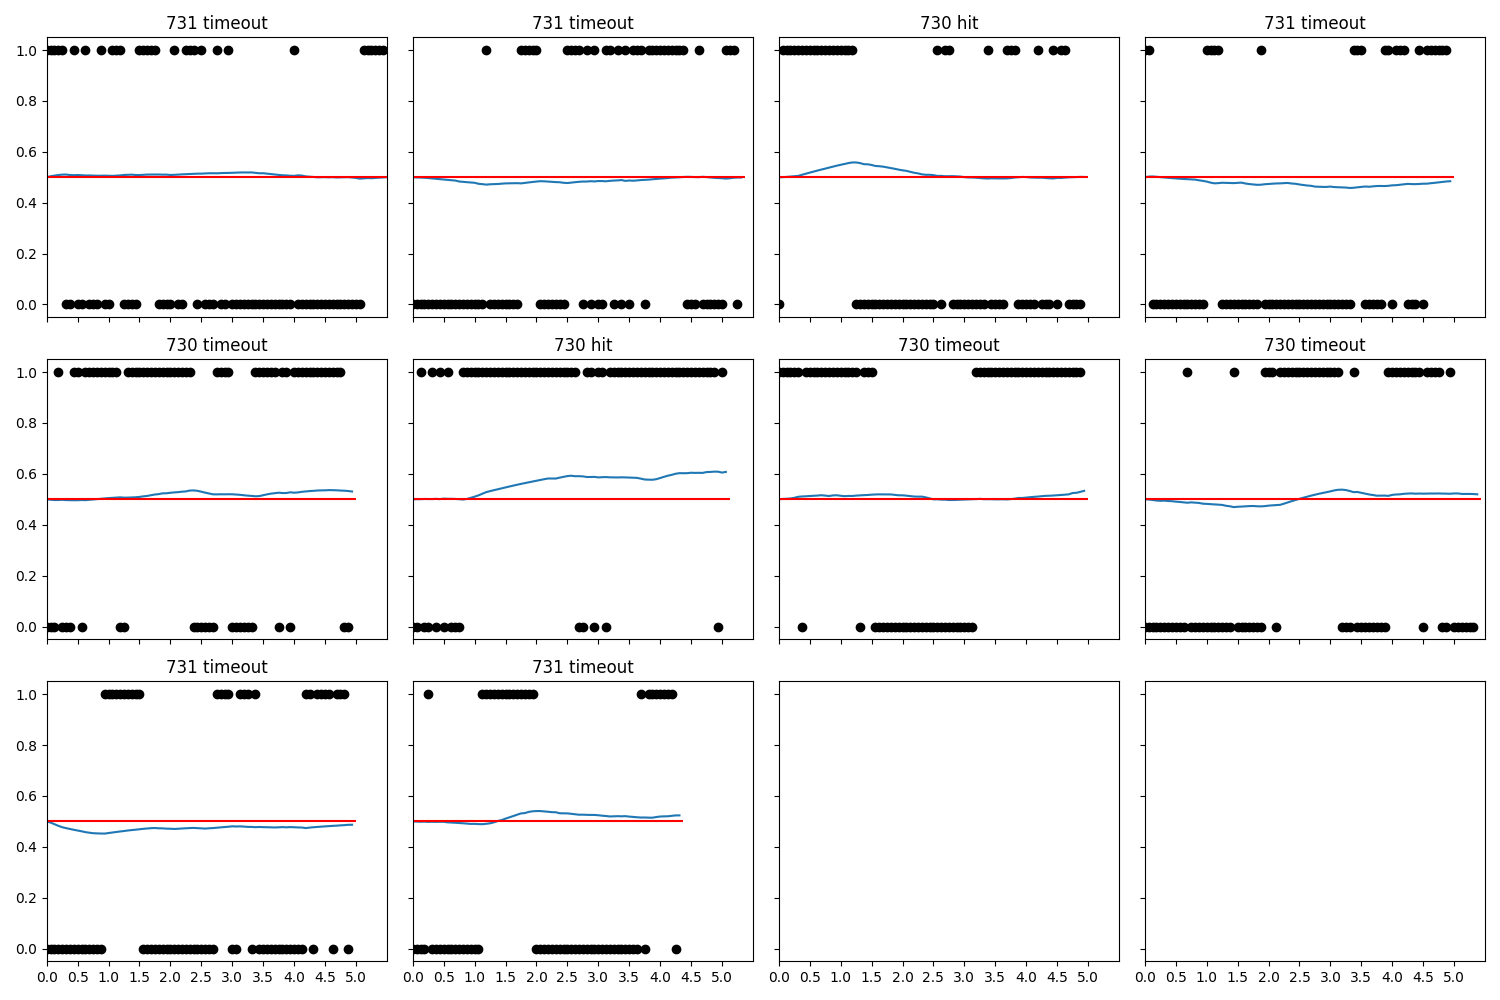

In [125]:
online_test(model_rF, X_test, y_test, alpha=0.98, ths=[0.55, 0.45], th_rej=0.5)

# PCA

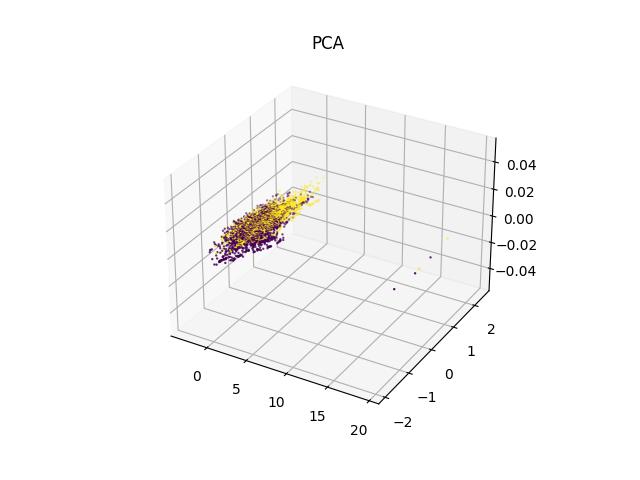

array([7.85197412e-01, 1.96529829e-01, 1.61515644e-02, 1.43789340e-03,
       6.83300985e-04])

In [139]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib widget
pca = PCA()
x_pca = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('PCA')
ax.scatter(x_pca[:, 0], x_pca[:, 1], s=0.5,c=y, cmap='viridis')
plt.show()

pca.explained_variance_ratio_

# BOh

In [28]:
info.keys()

dict_keys(['classes', 'sampleRate', 'selchs', 'files', 'band', 'cfStart', 'cfDur', 'filterOrder', 'startNewFile', 'startTest', 'idx_selchs'])

In [34]:
X_train.shape, X_test.shape

((2750, 17), (1111, 17))